# **Diamond Price Prediction**

### Frame the problem:
* The problem requires Supervised Learning. 
* The instances come with an expected output (i.e the diamond's price).
* Predicting the price(numerical) of a diamond from dataset is a Regression Task. More specifically, a Multivariate Regression Task.
* Evaluation metric will be RMSE 

## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # Python plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline

import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV   
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics
from pprint import pprint

## Importing train data

In [2]:
# Read the csv and creates the dataframe called train_df
train_df = pd.read_csv('data/train.csv')

## EDA

In [3]:
# Show first 5 rows of the data
train_df.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [4]:
# Show data shape (# rows, # columns)
train_df.shape

(43152, 11)

In [5]:
# Detect data-type of each feature, besides whether having null vlues or not
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


* Observe having cetegorical predictors that need to be handled and encoded
* Having no null values

In [6]:
# Look at the summary of the numerical attributes
train_df.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Min value of "x", "y", "z" are zero. This indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds, as it doesn’t make any sense to have length\width\depth of a diamond to be zero. So we need to filter out those as it clearly faulty data points.

In [7]:
# Dropping dimentionless diamonds
train_df = train_df[(train_df[['x','y','z']] != 0).all(axis=1)]
train_df.shape

(43135, 11)

*We had at the start 43152 diamonds, now we have 43135. It means that we "lost" only 17 diamonds.*

In [8]:
# Null values check
train_df.isnull().mean()

Id         0.0
carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
price      0.0
x          0.0
y          0.0
z          0.0
dtype: float64

*No Null values in train datasets*

In [9]:
# Check for duplicated rows
train_df.duplicated().sum()

0

*No duplicated data*

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>],
       [<AxesSubplot:title={'center':'table'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

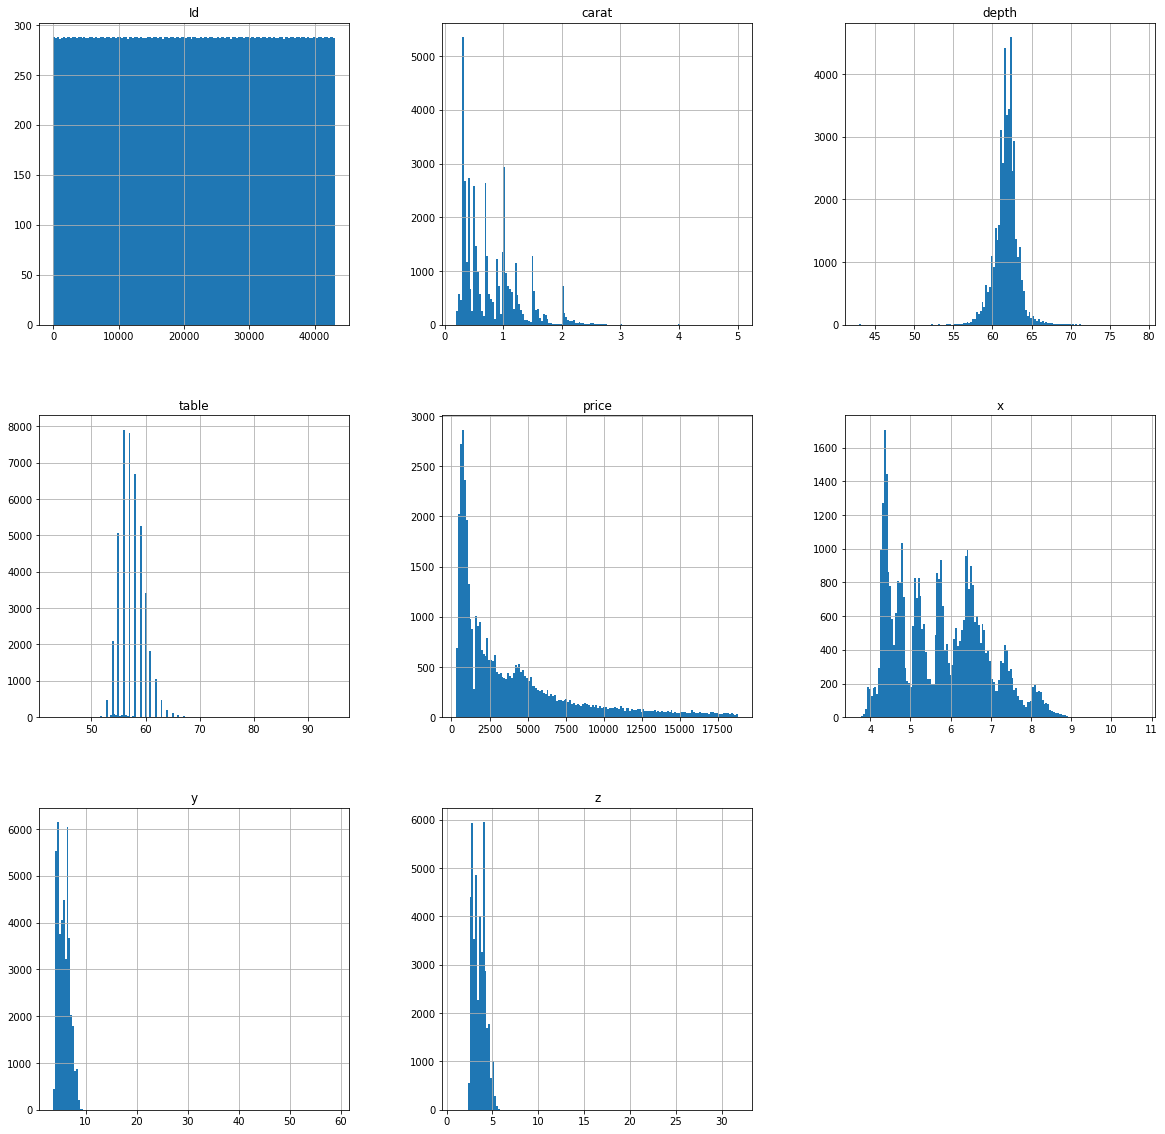

In [10]:
# Observe the distribution of the features
train_df.hist(figsize = (20,20),bins=150)

* Observe that 'Id' feature has uniform distribution, therefore we'll drop it, as its p-value is almost=1, besides It's a ratio data with just sequential numbers that has no relationship with the target variable and won't affect its results. Drop it
* 'Z' and 'y' features are confined to a certain small range
* 'price', 'carat', and 'x' features are right skewed, as they're decreasing over time
* 'carat' feature has a spike in a certain value around 0.35
* Most diamonds are roughly between 0.3 and 1.5 Carats.

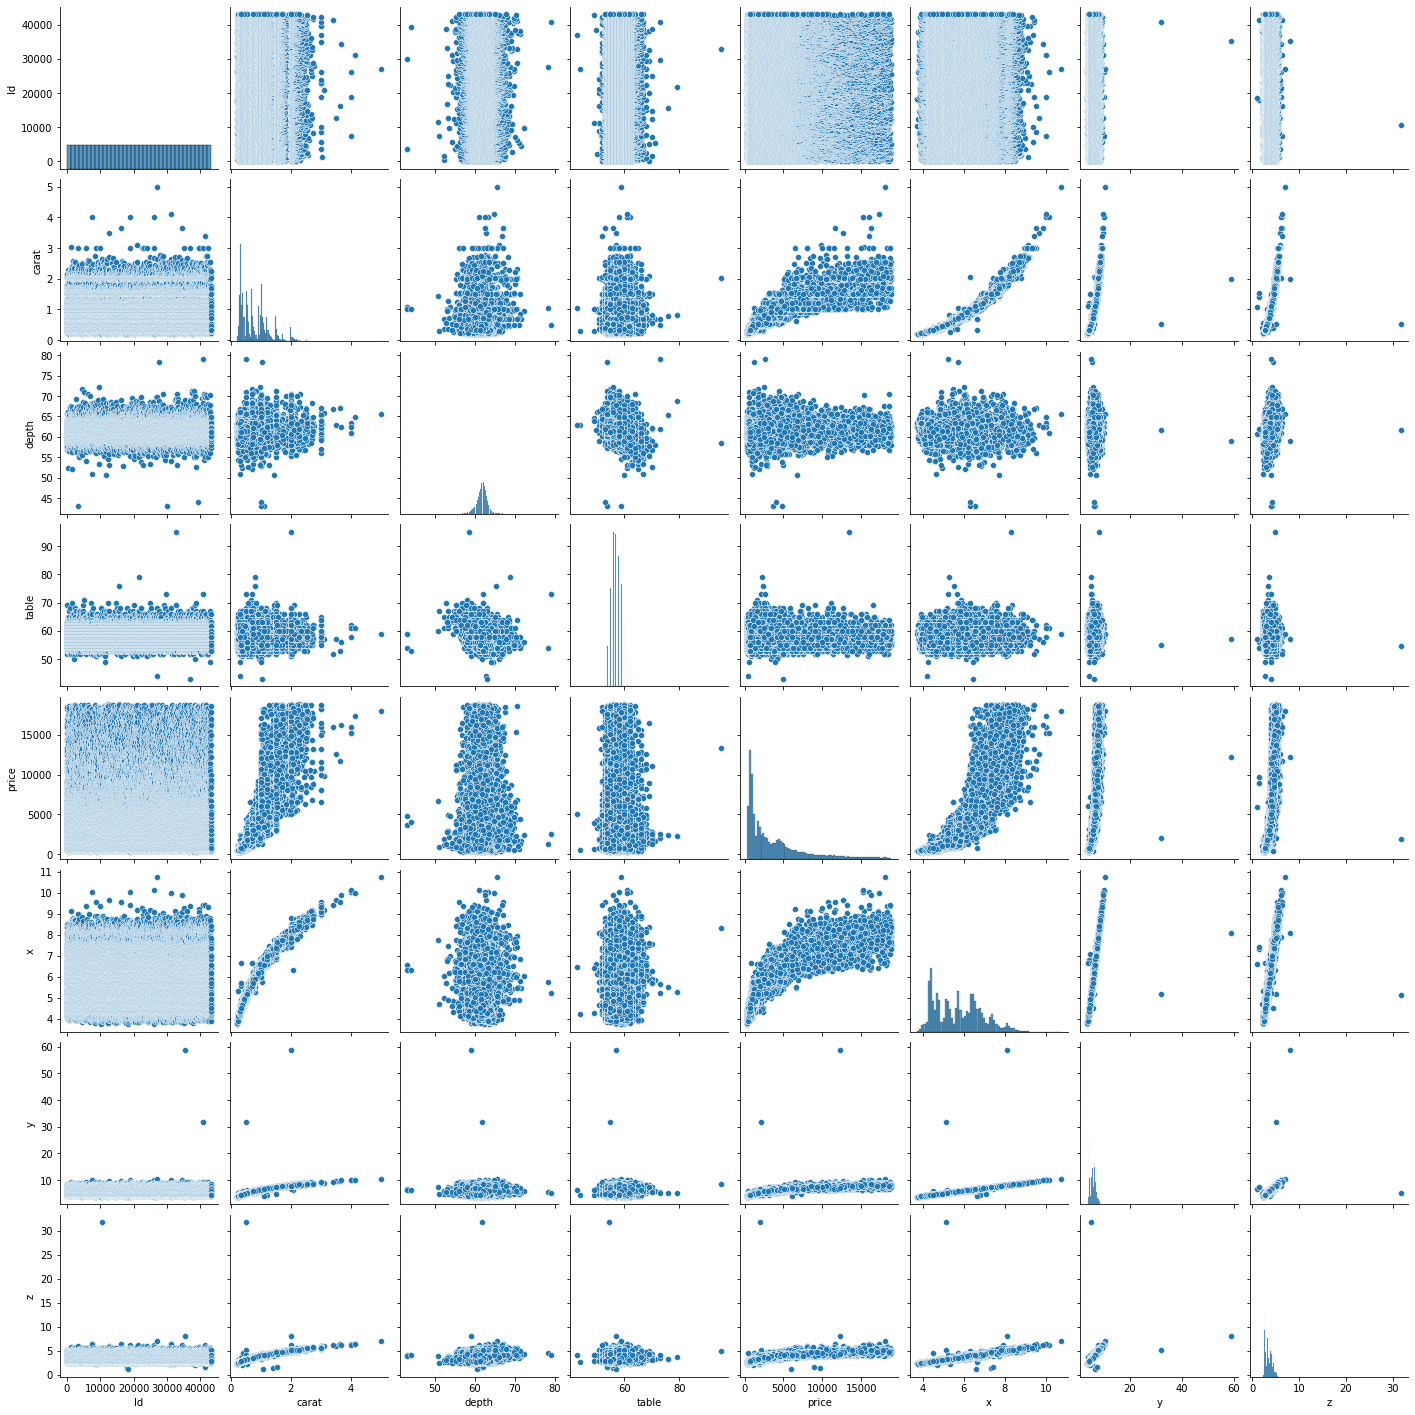

In [11]:
# Observe correlaiton between numerical features. Pay attention to spotting outliers 
sns.pairplot(data=train_df)
plt.show()

* 'carat', 'x', 'y', and 'z' are positively correlated with each other, with 3-4 outliers

<AxesSubplot:>

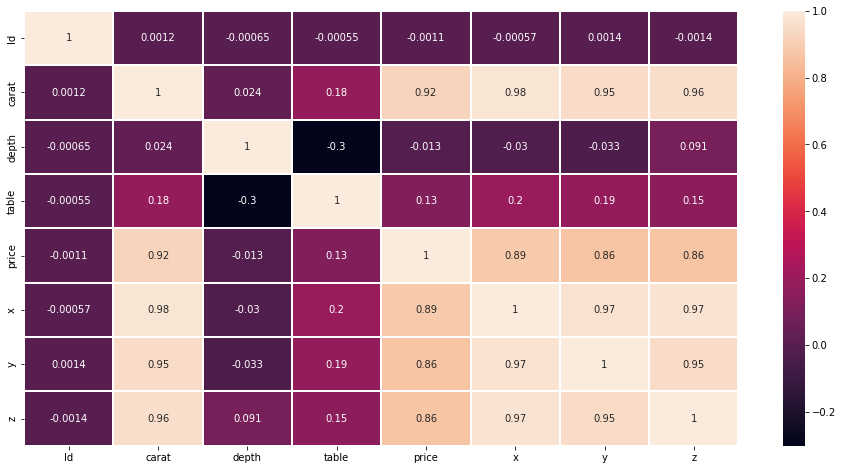

In [12]:
# Correlation matrix
plt.figure(figsize=(16, 8))
sns.heatmap(train_df.corr(), annot=True, linewidths=0.05)

* "depth" and "table" show low correlation with target variable(price). 
* 'carat', 'x', 'y', and 'z' have strong positive correlation with target variable(price)
* As expected from pairplot, 'carat', 'x', 'y', and 'z' are highly correlated with each other.
  these features need to be handled, as the predictors given to the machine to train on shouldn't be correlated with each other
* 'table' and 'carat' has low correlaiton with target variable(price)
* As expected, 'Id' has no correlaiton with any feature,as it has a uniform dstribution
#### Since 'carat' has the strongest correlation with 'price', we use this feature for our Stratified Sampling.

###### Plot a Pair-plot of Price vs. 4 Cs (Carat, Cut, Color, Clarity) — the most popular and marketed properties of a diamond.

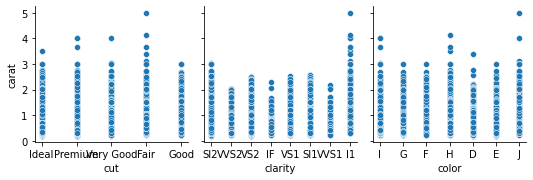

In [13]:
# plot carat vs other Cs
sns.pairplot(train_df, x_vars=['cut', 'clarity', 'color'], y_vars = ['carat'])
plt.show()

The biggest diamond (higher carat) fall in Fair cut, I1 clarity and H-I color

In [14]:
train_df['color'].value_counts()

G    9053
E    7832
F    7630
H    6645
D    5421
I    4264
J    2290
Name: color, dtype: int64

<AxesSubplot:xlabel='color', ylabel='count'>

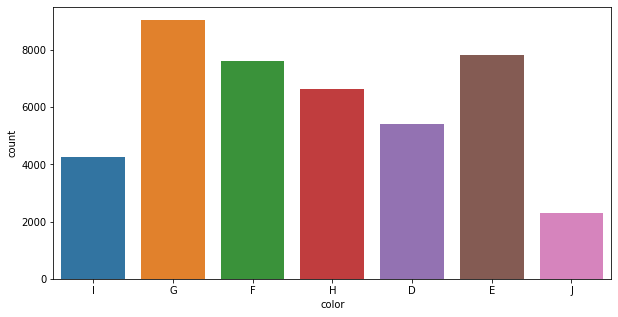

In [15]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['color'])

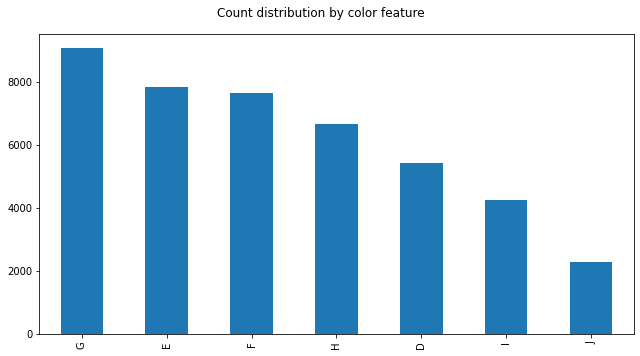

In [16]:
# Sorted
fig= plt.figure(figsize=(9,5))

fig.suptitle("Count distribution by color feature")
train_df['color'].value_counts().plot.bar()
plt.tight_layout()

Colors (G,E,F ) are more widespread in dataset

In [17]:
train_df['cut'].value_counts()

Ideal        17201
Premium      11103
Very Good     9657
Good          3878
Fair          1296
Name: cut, dtype: int64

Cut (Ideal) has the greatest  widespread in dataset   

<AxesSubplot:xlabel='cut', ylabel='count'>

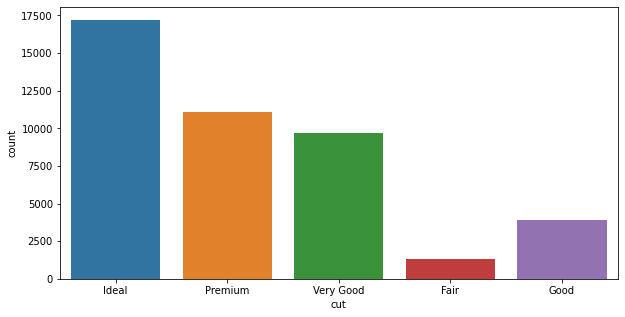

In [18]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['cut'])

In [19]:
train_df['clarity'].value_counts()

SI1     10426
VS2      9821
SI2      7424
VS1      6474
VVS2     4041
VVS1     2904
IF       1442
I1        603
Name: clarity, dtype: int64

<AxesSubplot:xlabel='clarity', ylabel='count'>

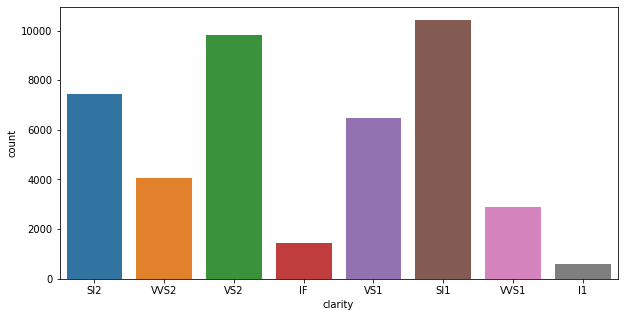

In [20]:
plt.figure(figsize = (10,5))
sns.countplot(x = train_df['clarity'])

Clarity (SI1 ,VS2 ,SI2 ) are more widespread in dataset 

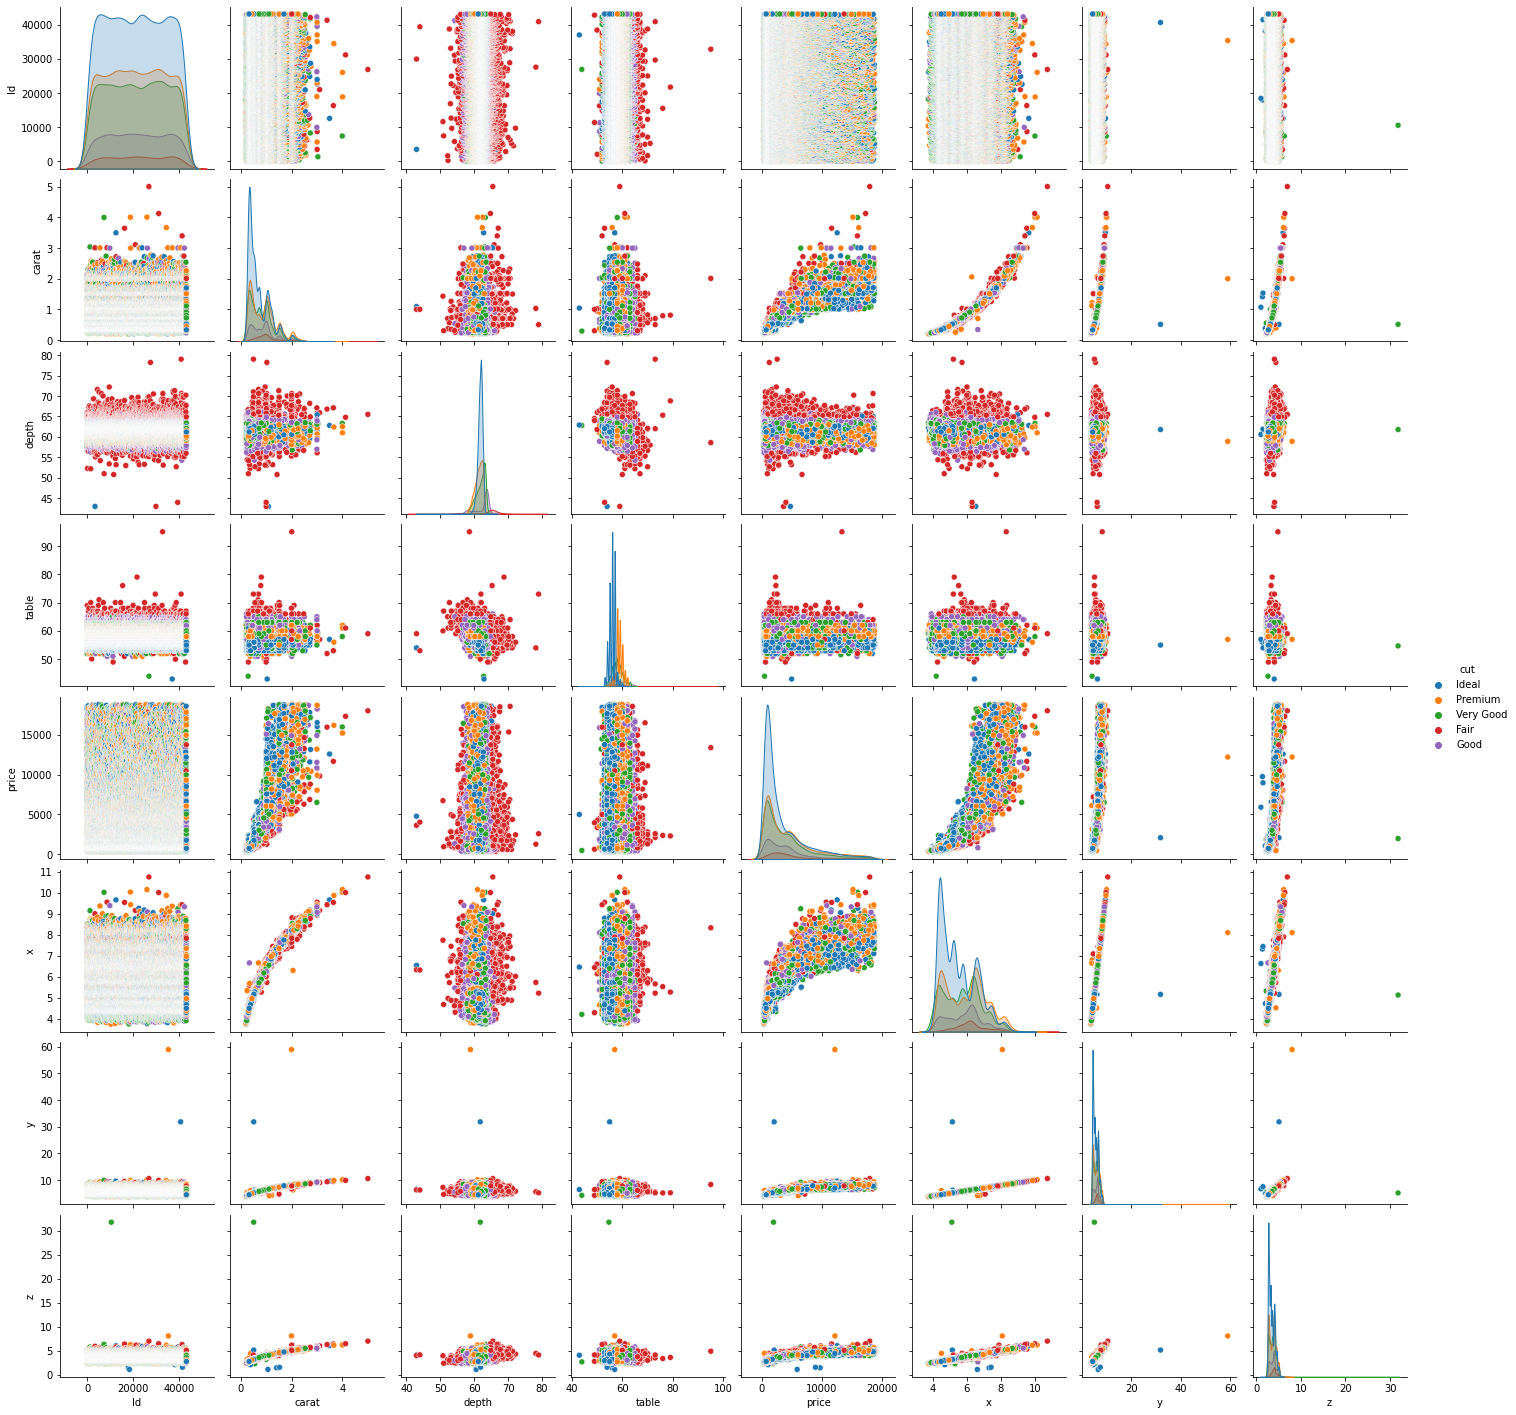

In [21]:
sns.pairplot(train_df, hue= "cut")

## Data Preparation Preprocessing

In [10]:
# Drop 'Id' column
train_df.drop('Id', 1, inplace=True)

In [11]:
num_cols_train = train_df.select_dtypes(exclude='object').columns.to_list()   
num_cols_train

['carat', 'depth', 'table', 'price', 'x', 'y', 'z']

In [12]:
# Remove Outliers
def removeoutliers(df, listvars, z):
    '''
    Detect outliers and remove them
    '''
    for var in listvars:
        df1 = df[np.abs(stats.zscore(df[var])) < z]
    return df1

train_clean = removeoutliers(train_df, num_cols_train,3)

In [13]:
train_df.shape

(43135, 10)

In [14]:
train_clean.shape

(43109, 10)

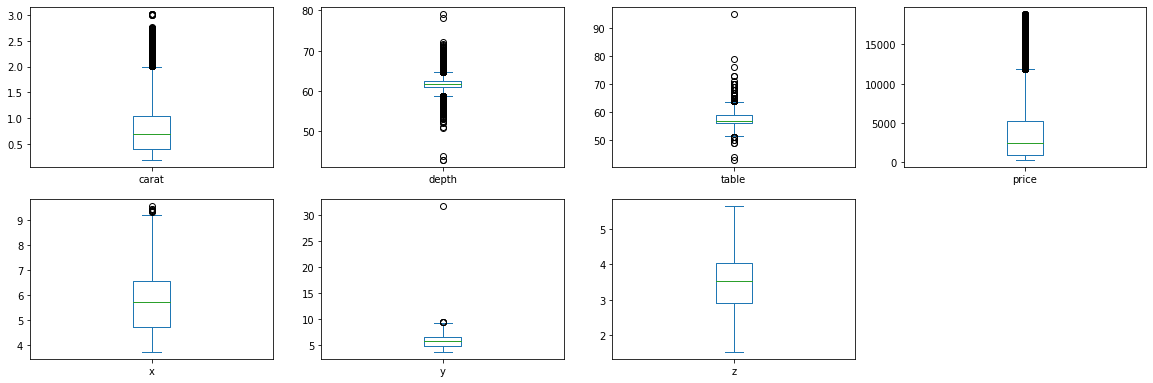

In [15]:
# Detect outliers from Box Plot
train_clean.plot(kind='box',figsize=(20,10),subplots=True,layout=(3,4))
plt.show()

In [16]:
# Remove outliers based on observations from Box Plot
train_clean = train_clean[(train_clean["depth"]<75)&(train_clean["depth"]>45)]
train_clean = train_clean[(train_clean["table"]<80)&(train_clean["table"]>40)]
train_clean = train_clean[(train_clean["y"]<15)]

In [17]:
train_clean.shape

(43102, 10)

6 observations have been removed

In [18]:
train_clean

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...,...
43147,0.52,Ideal,E,VS2,61.5,56.0,1760,5.16,5.18,3.18
43148,0.72,Very Good,D,VS2,62.1,59.0,3016,5.70,5.73,3.55
43149,0.44,Premium,I,VVS1,61.5,58.0,990,4.95,4.87,3.02
43150,0.31,Premium,E,VS1,60.2,58.0,734,4.38,4.43,2.65


In [19]:
def histplot(df, listvar):
    '''
    Plot data distribution with histogram plot
    '''
    fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
    counter=0
    for ax in axes:
        df.hist(column=listvar[counter], bins=20, ax=axes[counter])
        plt.ylabel('Price')
        plt.xlabel(listvar[counter])
        counter = counter+1
    plt.show()

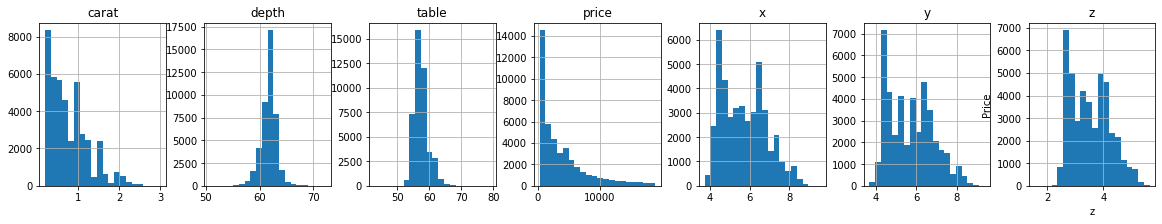

In [20]:
# Observe data distribution before applying log transformation
histplot(train_clean, num_cols_train)

In [21]:
# Take only independant variables, as log transformation shouldn't be applied on target variable
predictores = train_clean.drop('price', 1)

In [22]:
predictores

,carat,cut,color,clarity,depth,table,x,y,z
0,1.06,Ideal,I,SI2,61.8,57.0,6.57,6.60,4.07
1,1.51,Premium,G,VVS2,60.9,58.0,7.38,7.42,4.51
2,0.32,Ideal,F,VS2,61.3,56.0,4.43,4.41,2.71
3,0.53,Ideal,G,VS2,61.2,56.0,5.19,5.22,3.19
4,0.70,Premium,H,VVS2,61.0,57.0,5.76,5.72,3.50
...,...,...,...,...,...,...,...,...,...
43147,0.52,Ideal,E,VS2,61.5,56.0,5.16,5.18,3.18
43148,0.72,Very Good,D,VS2,62.1,59.0,5.70,5.73,3.55
43149,0.44,Premium,I,VVS1,61.5,58.0,4.95,4.87,3.02
43150,0.31,Premium,E,VS1,60.2,58.0,4.38,4.43,2.65


In [23]:
predictors_numerical_columns = num_cols_train.copy()

In [24]:
predictors_numerical_columns.remove('price')

In [25]:
predictors_numerical_columns

['carat', 'depth', 'table', 'x', 'y', 'z']

In [26]:
# As most properties are not normally distributed, we need to apply log transformation 
def convertfeatures2log(df, predictors_numerical_columns):
    for var in predictors_numerical_columns:
        train_clean[var] = np.log(train_clean[var])

convertfeatures2log(predictores, predictors_numerical_columns)

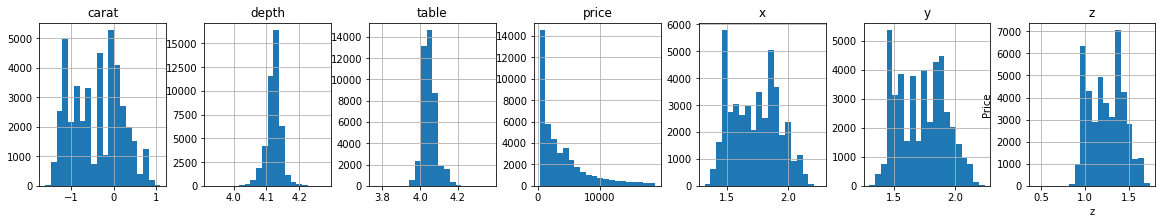

In [27]:
histplot(train_clean, num_cols_train)

array([[<AxesSubplot:title={'center':'carat'}>,
        <AxesSubplot:title={'center':'depth'}>,
        <AxesSubplot:title={'center':'table'}>],
       [<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

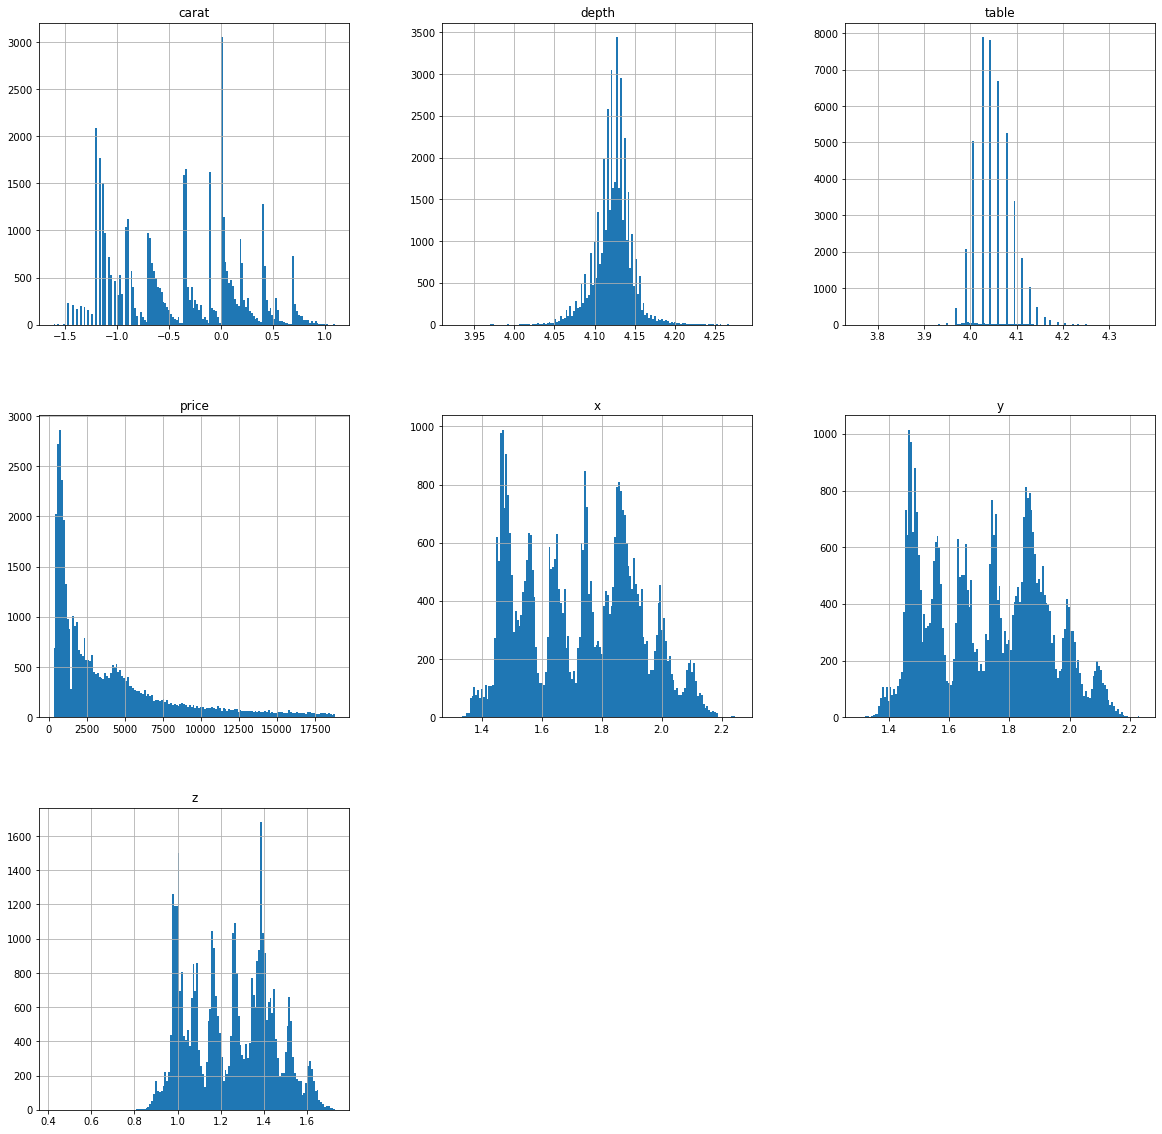

In [28]:
# Observe the distribution more clearly with less bin size
train_clean.hist(figsize = (20,20),bins=150)

In [29]:
train_clean

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.058269,Ideal,I,SI2,4.123903,4.043051,4270,1.882514,1.887070,1.403643
1,0.412110,Premium,G,VVS2,4.109233,4.060443,15164,1.998774,2.004179,1.506297
2,-1.139434,Ideal,F,VS2,4.115780,4.025352,828,1.488400,1.483875,0.996949
3,-0.634878,Ideal,G,VS2,4.114147,4.025352,1577,1.646734,1.652497,1.160021
4,-0.356675,Premium,H,VVS2,4.110874,4.043051,2596,1.750937,1.743969,1.252763
...,...,...,...,...,...,...,...,...,...,...
43147,-0.653926,Ideal,E,VS2,4.119037,4.025352,1760,1.640937,1.644805,1.156881
43148,-0.328504,Very Good,D,VS2,4.128746,4.077537,3016,1.740466,1.745716,1.266948
43149,-0.820981,Premium,I,VVS1,4.119037,4.060443,990,1.599388,1.583094,1.105257
43150,-1.171183,Premium,E,VS1,4.097672,4.060443,734,1.477049,1.488400,0.974560


## Encoding categorical predictors
##### A crucial transformation step in data preprocessing should be done, as scikit-learn accepts only numerical features
Apply label encoder to each column with categorical data (color,cut,clarity) 

In [30]:
cat_cols_train = train_clean.select_dtypes(include='object').columns.to_list()  

In [31]:
for i in cat_cols_train:
    print(train_clean[i].unique())

['Ideal' 'Premium' 'Very Good' 'Fair' 'Good']
['I' 'G' 'F' 'H' 'D' 'E' 'J']
['SI2' 'VVS2' 'VS2' 'IF' 'VS1' 'SI1' 'VVS1' 'I1']


In [32]:
def categoricals_label_encoder(train_clean, cat_cols_train):
    '''
    Convert categorical variables into numerical, using LabelEncoder()
    '''
    
    # Make copy to avoid changing original data 
    train_label = train_clean.copy()

    # Apply label encoder to each column with categorical data
    label_encoder = LabelEncoder()

    for col in cat_cols_train:
        train_label[col] = label_encoder.fit_transform(train_label[col]) 
        
    return train_label

In [33]:
# categoricals_label_encoder(data, categorical_columns_names)
train_label = categoricals_label_encoder(train_clean, cat_cols_train)

train_label.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.058269,2,5,3,4.123903,4.043051,4270,1.882514,1.887070,1.403643
1,0.412110,3,3,7,4.109233,4.060443,15164,1.998774,2.004179,1.506297
2,-1.139434,2,2,5,4.115780,4.025352,828,1.488400,1.483875,0.996949
3,-0.634878,2,3,5,4.114147,4.025352,1577,1.646734,1.652497,1.160021
4,-0.356675,3,4,7,4.110874,4.043051,2596,1.750937,1.743969,1.252763


In [34]:
for i in cat_cols_train:
    print(train_label[i].unique())

[2 3 4 0 1]
[5 3 2 4 0 1 6]
[3 7 5 1 4 2 6 0]


In [35]:
train_label.groupby(['table'])['price'].value_counts(normalize=True)

table     price
3.761200  4997     1.000000
3.784190  474      1.000000
3.891820  630      0.500000
          3951     0.500000
3.912023  4227     1.000000
                     ...   
4.248495  11102    0.166667
4.262680  1633     1.000000
4.290459  2100     1.000000
4.330733  2362     1.000000
4.369448  2301     1.000000
Name: price, Length: 26989, dtype: float64

## Feature Engineering

####  Create New Feature 'Volume'

In [36]:
train_label['volume'] = train_label['x']*train_label['y']*train_label['z']
train_label.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.058269,2,5,3,4.123903,4.043051,4270,1.882514,1.887070,1.403643,4.986350
1,0.412110,3,3,7,4.109233,4.060443,15164,1.998774,2.004179,1.506297,6.034076
2,-1.139434,2,2,5,4.115780,4.025352,828,1.488400,1.483875,0.996949,2.201859
3,-0.634878,2,3,5,4.114147,4.025352,1577,1.646734,1.652497,1.160021,3.156676
4,-0.356675,3,4,7,4.110874,4.043051,2596,1.750937,1.743969,1.252763,3.825412


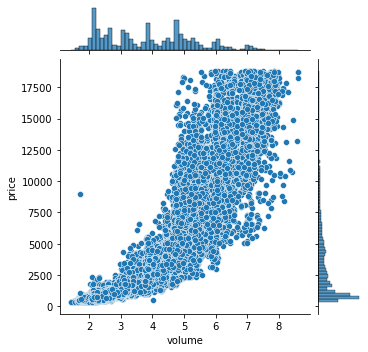

In [37]:
sns.jointplot(x='volume', y='price' , data=train_label, size=5)

In [38]:
train_label.drop(['x','y','z'], axis=1, inplace= True)

In [39]:
#train_label.columns
train_columns = train_label.columns
train_columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price',
       'volume'],
      dtype='object')

###### Split training data into X(predictors) and y(target variable)

In [40]:
X_train=train_label.drop(['price'],axis=1)
y_train=train_label['price']

## Feature Scaling

###### Use Standardization, as It's much less affected by outliers than normalization

In [41]:
# Standardize predictors
scale = StandardScaler()
train_label = scale.fit_transform(X_train) 
train_label

array([[ 0.77857746, -0.54176367,  1.41456843, ...,  0.0488764 ,
        -0.18924918,  0.76119831],
       [ 1.38477198,  0.43270103,  0.23916111, ..., -0.58710189,
         0.26498812,  1.48725808],
       [-1.27330925, -0.54176367, -0.34854255, ..., -0.30329241,
        -0.6515265 , -1.16841565],
       ...,
       [-0.72773921,  0.43270103,  1.41456843, ..., -0.1620814 ,
         0.26498812, -0.75495937],
       [-1.32770064,  0.43270103, -0.93624621, ..., -1.08828369,
         0.26498812, -1.2095441 ],
       [-1.22059172, -0.54176367,  0.23916111, ..., -0.37407079,
        -1.12213358, -1.12579461]])

In [42]:
print(train_clean.shape)
print(train_label.shape)
print(X_train.shape)
print(y_train.shape)

(43102, 10)
(43102, 7)
(43102, 7)
(43102,)


## Model Selection

In [44]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [45]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [46]:
random_forst = RandomForestRegressor()
random_forst.fit(X_train, y_train)

RandomForestRegressor()

In [47]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [48]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [49]:
# List of all the models
models = [lin_reg, decision_tree, random_forst, knn, xgbr]

# Dictionary of model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

In [86]:
cv_results_rms = []
for i, model in enumerate(models):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print(f'{pipe_dict[i]}: {(-cv_score).mean()}')    

LinearRegression: 1323.6339646814683
DecisionTree: 726.2418500191096
RandomForest: 551.3632272478603
KNeighbors: 640.0894554568392
XGBRegressor: 544.713497413658


* Take the model with the least RMSE, that is, XGBRegressor
* Let's test this model on a test set and evaluate it with different parameters, tune its parameters.

## Hyperparameteres Tuning 

In [51]:
xgbr = XGBRegressor(random_state = 42)
pprint(xgbr.get_params())

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [52]:
params_dict = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2),
    'subsample':[i/10.0 for i in range(6,10)], 
    'colsample_bytree':[i/10.0 for i in range(6,10)], 
    'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] 
}

As running Grid Search with 3-fold cv takes hours to finish the process, I haven't implemented it at the last time 

In [ ]:
# Grid search of parameters, using 3 fold cross validation, 
xgbr_grid = GridSearchCV(estimator = xgbr, # the base model 
                         param_grid = params_dict, # grid of hyper parameters
                         cv = 3, # 3-fold
                         n_jobs = 1 # use all cores in the machine to train (parallel)
                         scoring = 'neg_mean_squared_error')   

In [54]:
#xgbr_grid.fit(X_train, y_train)

In [55]:
#xgbr_grid.best_params_

In [56]:
#xgbr_grid.best_estimator_

In [57]:
#xgbr_grid

In [58]:
#xgbr_grid.best_score_

In [59]:
# Best params gained from Grid Search
xgbr = XGBRegressor(random_state = 42, colsample_bytree= 0.9, \
                    gamma= 0.1, max_depth= 9, min_child_weight= 5,\
                    reg_alpha= 0.1, subsample= 0.9)

In [60]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.1, reg_lambda=1, ...)

## Test data

In [61]:
test_df=pd.read_csv('data/test.csv')

In [62]:
test_df.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,Ideal,G,VVS2,61.1,57.0,4.52,4.48,2.75
1,2,0.71,Premium,E,VS2,62.7,58.0,5.74,5.68,3.58
2,3,0.44,Very Good,I,VS1,62.8,56.0,4.83,4.88,3.05
3,4,0.81,Premium,E,SI2,60.1,59.0,6.09,6.03,3.65
4,5,0.40,Ideal,G,VVS1,61.2,56.0,4.74,4.80,2.92


In [63]:
test_df.shape

(10788, 10)

In [64]:
test_df.duplicated().sum()

0

In [65]:
test_df.isnull().mean()

Id         0.0
carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
x          0.0
y          0.0
z          0.0
dtype: float64

In [66]:
ids = test_df['Id']
ids

0            1
1            2
2            3
3            4
4            5
         ...  
10783    10784
10784    10785
10785    10786
10786    10787
10787    10788
Name: Id, Length: 10788, dtype: int64

In [67]:
# Drop Id column
test_df.drop('Id', 1, inplace=True)

## Feature Encoding

In [68]:
cat_cols_test = test_df.select_dtypes(include='object').columns.to_list()  

In [69]:
cat_cols_test

['cut', 'color', 'clarity']

In [70]:
# Encoding categorical data, that is, convert them into numericals
# Parameters: data, categorical_columns_names
test_label = categoricals_label_encoder(test_df, cat_cols_test)

test_label.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.34,2,3,7,61.1,57.0,4.52,4.48,2.75
1,0.71,3,1,5,62.7,58.0,5.74,5.68,3.58
2,0.44,4,5,4,62.8,56.0,4.83,4.88,3.05
3,0.81,3,1,3,60.1,59.0,6.09,6.03,3.65
4,0.40,2,3,6,61.2,56.0,4.74,4.80,2.92


####  Create New Feature 'Volume'

In [71]:
test_label['volume'] = test_label['x']*test_label['y']*test_label['z']
test_label.head()

,carat,cut,color,clarity,depth,table,x,y,z,volume
0,0.34,2,3,7,61.1,57.0,4.52,4.48,2.75,55.686400
1,0.71,3,1,5,62.7,58.0,5.74,5.68,3.58,116.719456
2,0.44,4,5,4,62.8,56.0,4.83,4.88,3.05,71.889720
3,0.81,3,1,3,60.1,59.0,6.09,6.03,3.65,134.037855
4,0.40,2,3,6,61.2,56.0,4.74,4.80,2.92,66.435840


In [72]:
test_label.drop(['x','y','z'], axis=1, inplace= True)

In [73]:
num_cols_test = test_label.select_dtypes(exclude='object').columns.to_list()    
num_cols_test

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'volume']

In [74]:
test_label.shape

(10788, 7)

## Feature Scaling
#### As features has different scales and ranges, we'll standardize them

In [75]:
test_scaled = scale.transform(test_label) 
test_scaled

array([[ 1.26123484e+00, -5.41763671e-01,  2.39161111e-01, ...,
         2.47006198e+03,  1.38293962e+03,  3.58956368e+01],
       [ 1.89511316e+00,  4.32701035e-01, -9.36246211e-01, ...,
         2.53942477e+03,  1.40905761e+03,  7.81907068e+01],
       [ 1.43255330e+00,  1.40716574e+00,  1.41456843e+00, ...,
         2.54375994e+03,  1.35682164e+03,  4.71243152e+01],
       ...,
       [ 1.89511316e+00, -5.41763671e-01, -9.36246211e-01, ...,
         2.52208407e+03,  1.33070365e+03,  7.72334322e+01],
       [ 2.58038701e+00,  4.32701035e-01, -9.36246211e-01, ...,
         2.46572680e+03,  1.46129358e+03,  1.22784346e+02],
       [ 4.10512134e+00,  4.32701035e-01, -3.48542550e-01, ...,
         2.48740268e+03,  1.43517560e+03,  2.14962610e+02]])

In [76]:
test_scaled.shape

(10788, 7)

# Model Evaluation

In [77]:
y_train_pred = xgbr.predict(X_train)

mse = mean_squared_error(y_train,y_train_pred)
RMSE = np.sqrt(mse)

print(RMSE)

302.3734866756126


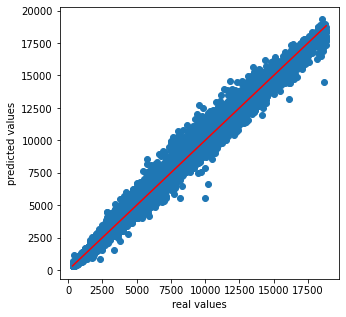

In [78]:
plt.figure(figsize=(5, 5))
plt.scatter(y_train, y_train_pred)
plt.ylabel("predicted values")
plt.xlabel("real values")

#find min and max for y_train
minimum = math.ceil(y_train.min())
maximum = math.ceil(y_train.max())

#plot a diagonal line accross the scattered plot to better see the difference in values
#idealy all points should be on the diagonal line
plt.plot( [minimum,maximum],[minimum,maximum], color='red')

In [79]:
results = {}
results["Predicted"] = y_train_pred.round(2)
results["Reality"] = y_train

result_df = pd.DataFrame(results)
result_df

,Predicted,Reality
0,4236.859863,4270
1,15062.679688,15164
2,715.539978,828
3,1620.430054,1577
4,2628.110107,2596
...,...,...
43147,1713.319946,1760
43148,3206.790039,3016
43149,1023.739990,990
43150,801.640015,734


In [80]:
X_test = test_scaled.copy()

In [81]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(43102, 7)
(43102,)
(10788, 7)


In [82]:
y_pred = xgbr.predict(X_test)
y_pred

array([15546.835, 16288.351, 11276.246, ..., 16881.758, 10916.133,
       10916.133], dtype=float32)

In [83]:
final=pd.Series(y_pred)
final

0        15546.834961
1        16288.350586
2        11276.246094
3        10916.132812
4        16881.757812
             ...     
10783    10674.517578
10784    16288.350586
10785    16881.757812
10786    10916.132812
10787    10916.132812
Length: 10788, dtype: float32

In [84]:
final_dic={'Id': ids,
          'Price': final}

final_df=pd.DataFrame(final_dic)
final_df

,Id,Price
0,1,15546.834961
1,2,16288.350586
2,3,11276.246094
3,4,10916.132812
4,5,16881.757812
...,...,...
10783,10784,10674.517578
10784,10785,16288.350586
10785,10786,16881.757812
10786,10787,10916.132812


In [85]:
final_df.to_csv('submission.csv', index=False)